We will follow the architecture of Variational Autoencoder to compress the representation into a latent space first. Then we will pass it through the probabilistic decoder for one simulation and see if it can reconstruct things at all time series.

Reference notebook: See `global/homes/a/ajivani/VAE_Cahn_Hillard.ipynb`. Based off https://github.com/sedaoturak/vae_cahn-hilliard/blob/main/VAE_Cahn_Hillard.ipynb

Basically if this works we can make two improvements:

1. Run Neural ODE on learnt latent space samples

2. Put in an additional conditional step on VAE e.g. passing in flux rope parameters as a so called "label" or "latent feature" we want to learn representation on.

In [2]:
import os
import scipy.signal
os.getcwd()

'/global/u1/a/ajivani/WLROM/WhiteLight'

In [3]:
current_dir = os.getcwd()

In [4]:
import numpy as np
from numpy import ogrid
import pandas as pd
import scipy.linalg as la
import scipy.sparse as sparse
import matplotlib.pyplot as plt

import copy

In [5]:
%matplotlib inline

In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
import time

In [8]:
from sunpy.visualization import colormaps as cm

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [10]:
import argparse

In [11]:
parser = argparse.ArgumentParser()
parser.add_argument('--tol', type=float, default=1e-3)
parser.add_argument('--adjoint', type=eval, default=True, choices=[True, False])
parser.add_argument('--lr', type=float, default=0.1)
parser.add_argument('--debug', action='store_true')
parser.add_argument('-runCNN', type=eval, default=True, choices=[True, False])
parser.add_argument('-resize', type=eval, default=False, choices=[True, False]) # whether or not to resize the images. We will try wo resizing for VAE!!!
parser.add_argument('-latent_dim', type=int, default=16)

args = parser.parse_args(args=())

In [12]:
args

Namespace(adjoint=True, debug=False, latent_dim=16, lr=0.1, resize=False, runCNN=True, tol=0.001)

In [13]:
args.tol

0.001

In [14]:
!pip install -q --user torchdiffeq

In [15]:
if args.adjoint:
    from torchdiffeq import odeint_adjoint as odeint
else:
    from torchdiffeq import odeint

In [16]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [17]:
device

device(type='cuda', index=0)

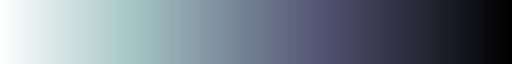

In [18]:
lc3 = cm.cmlist['soholasco3'].reversed()
lc3

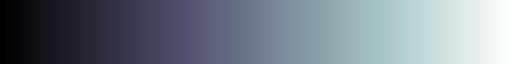

In [19]:
lc3_reg = cm.cmlist['soholasco3']
lc3_reg

In [20]:
plt.rc("axes.spines", right=True, top=True)
plt.rc("figure", dpi=300, 
       figsize=(9, 3)
      )
plt.rc("font", family="serif")
plt.rc("legend", edgecolor="none", frameon=True)
plt.style.use("dark_background")

In [21]:
import sys
# sys.path.insert(1, '/home/ajivani/WLROM/EdgeSS')
sys.path.insert(1, os.path.join(current_dir, "..", "EdgeSS"))

In [22]:
import edge_utils as edut

In [23]:
import cnn_utils as ut

### RESIZE DATA APPROPRIATELY

In [24]:
X_orig = np.load("./CR2161_tDecay2h_Polar_Compressed.npy")

In [25]:
X_orig.shape

(64, 256, 90, 278)

In [26]:
X = X_orig.reshape((64 * 256, 90, 278))[:, :, :]

In [27]:
X.shape

(16384, 90, 278)

In [28]:
sid=0

In [29]:
ed_2161, sd_2161 = edut.load_edge_data_blobfree(2161)

In [30]:
tMinIdx, tMin, tMaxIdx, tMax = edut.getTMinTMax(ed_2161, simIdx=sid)

In [31]:
tMinIdx

11

In [32]:
tMaxIdx

79

In [33]:
all_times = np.linspace(2, 180, 90)

In [34]:
valid_times = np.arange(tMin, tMax + 2, step=2)
valid_times

array([ 24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,  44.,
        46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,  66.,
        68.,  70.,  72.,  74.,  76.,  78.,  80.,  82.,  84.,  86.,  88.,
        90.,  92.,  94.,  96.,  98., 100., 102., 104., 106., 108., 110.,
       112., 114., 116., 118., 120., 122., 124., 126., 128., 130., 132.,
       134., 136., 138., 140., 142., 144., 146., 148., 150., 152., 154.,
       156., 158., 160.])

In [35]:
validTimeStartIdx = np.argwhere(all_times == valid_times[0])[0][0]
validTimeStartIdx

11

In [36]:
tTrainEnd = tMin + np.floor((2/3)*(tMax - tMin))
tTrainEnd

114.0

In [37]:
trainEndIdx = np.argwhere(valid_times == tTrainEnd)[0][0]
trainEndIdx

45

In [38]:
trainEndIdxAllTimes = np.argwhere(all_times == tTrainEnd)[0][0]
trainEndIdxAllTimes

56

In [39]:
all_times[(trainEndIdxAllTimes + 1):]

array([116., 118., 120., 122., 124., 126., 128., 130., 132., 134., 136.,
       138., 140., 142., 144., 146., 148., 150., 152., 154., 156., 158.,
       160., 162., 164., 166., 168., 170., 172., 174., 176., 178., 180.])

In [40]:
tTrain = valid_times[:(trainEndIdx + 1)]

In [41]:
tTrain

array([ 24.,  26.,  28.,  30.,  32.,  34.,  36.,  38.,  40.,  42.,  44.,
        46.,  48.,  50.,  52.,  54.,  56.,  58.,  60.,  62.,  64.,  66.,
        68.,  70.,  72.,  74.,  76.,  78.,  80.,  82.,  84.,  86.,  88.,
        90.,  92.,  94.,  96.,  98., 100., 102., 104., 106., 108., 110.,
       112., 114.])

In [42]:
tTest = valid_times[(trainEndIdx + 1):]
tTest

array([116., 118., 120., 122., 124., 126., 128., 130., 132., 134., 136.,
       138., 140., 142., 144., 146., 148., 150., 152., 154., 156., 158.,
       160.])

In [43]:
tTrainScaled = (tTrain - tMin) / (tMax - tMin)
tTestScaled = (tTest - tMin) / (tMax - tMin)

tAllScaled = (valid_times - tMin) / (tMax - tMin)

In [44]:
tAllScaled.shape

(69,)

In [45]:
nTrain = len(tTrain)
nTrain

46

In [46]:
x_orig_torch_full = X_orig[:, :, tMinIdx:(tMaxIdx + 1), sid]
x_orig_torch_full = x_orig_torch_full.transpose((2, 0, 1))
x_orig_torch_full = torch.from_numpy(np.expand_dims(np.float32(x_orig_torch_full), axis=1)).to(device)

x_orig_torch_full.shape

torch.Size([69, 1, 64, 256])

In [47]:
import torchvision
import torchvision.transforms as T

rs_dims = (32, 128)

In [48]:
# Slice data for a particular sID!
x_train_orig = X_orig[:, :, validTimeStartIdx:(trainEndIdxAllTimes + 1), sid]
x_train_orig = x_train_orig.transpose((2, 0, 1))
x_train_orig_torch = torch.from_numpy(np.expand_dims(np.float32(x_train_orig), axis=1)).to(device)

x_orig_torch_full = X_orig[:, :, tMinIdx:(tMaxIdx + 1), sid]
x_orig_torch_full = x_orig_torch_full.transpose((2, 0, 1))
x_orig_torch_full = torch.from_numpy(np.expand_dims(np.float32(x_orig_torch_full), axis=1)).to(device)

x_train_flat = X[:, validTimeStartIdx:(trainEndIdxAllTimes + 1), sid]
x_train_flat = x_train_flat.transpose((1, 0))
x_train_flat_torch = torch.from_numpy(np.expand_dims(np.float32(x_train_flat), axis=1)).to(device)

if args.resize:
    x_train_orig_torch = T.Resize(size=rs_dims, antialias=True)(x_train_orig_torch)
    x_orig_torch_full = T.Resize(size=rs_dims, antialias=True)(x_orig_torch_full)
    x_train_flat_torch = x_train_orig_torch.flatten(start_dim=2, end_dim=3)

x_orig_torch_full.shape, x_train_orig_torch.shape, x_train_flat_torch.shape

(torch.Size([69, 1, 64, 256]),
 torch.Size([46, 1, 64, 256]),
 torch.Size([46, 1, 16384]))

In [49]:
x0_train_orig = x_train_orig[tMinIdx, :, :]
x0_train_orig_torch = torch.from_numpy(np.expand_dims(np.float32(x0_train_orig), axis=(0, 1))).to(device)

if args.resize:
    x0_train_orig_torch = T.Resize(size=rs_dims, antialias=True)(x0_train_orig_torch)


# x0_train_flat = x0_train_orig.flatten()
# x0_train_flat_torch = torch.from_numpy(np.float32(x0_train_flat)).reshape((1, len(x0_train_flat))).to(device)

x0_train_flat_torch = torch.flatten(x0_train_orig_torch, start_dim=1)

x0_train_orig_torch.shape, x0_train_flat_torch.shape

(torch.Size([1, 1, 64, 256]), torch.Size([1, 16384]))

In [50]:
torch.flatten(x_train_orig_torch, start_dim=2, end_dim=3).shape

torch.Size([46, 1, 16384])

In [51]:
t_train_torch = torch.tensor(np.float32(tTrainScaled)).to(device)
t_torch_full = torch.tensor(np.float32(tAllScaled)).to(device)

t_torch_full.shape, t_train_torch.shape

(torch.Size([69]), torch.Size([46]))

In [52]:
data_size = t_train_torch.shape[0]
batch_time = 5
batch_size = 10

#### Define Convolutional VAE architecture.

Since the Fully Connected layers would map to latent dimension here and not a full flattened image, the number of parameters will not grow as quickly.

We need to check if we still need the `GroupNorm` we were defining for the original CNN based architecture.

In [53]:
kernel_size = 4
init_channels = 16
image_channels = 1
latent_dim = args.latent_dim

In [54]:
class ConvVAE(nn.Module):
    def __init__(self, ldim):
        super(ConvVAE, self).__init__()

        # encoder
        self.enc1 = nn.Conv2d(in_channels=image_channels, out_channels=init_channels*4, kernel_size=kernel_size - 1,
            stride=2, padding=1)
        self.enc2 = nn.Conv2d(in_channels=init_channels*4, out_channels=init_channels*8, kernel_size=kernel_size - 1,
            stride=2, padding=1)
        self.enc3 = nn.Conv2d(in_channels=init_channels*8, out_channels=init_channels*8, kernel_size=kernel_size - 1,
            stride=2, padding=1)
        self.enc4 = nn.Conv2d(in_channels=init_channels*8, out_channels=64, kernel_size=kernel_size - 1,
            stride=2, padding=1)
        self.dropout = nn.Dropout(0.25)
        # fully connected layers for learning representations
        self.fc1 = nn.Linear(64 * 4 * 16, 128)  # Adjust the input size
        self.fc_mu = nn.Linear(128, ldim)
        self.fc_log_var = nn.Linear(128, ldim)
        self.fc2 = nn.Linear(ldim, 64 * 4 * 16)  # Adjust the output size
        # decoder
        self.dec1 = nn.ConvTranspose2d(in_channels=64, out_channels=init_channels*8, kernel_size=kernel_size,
            stride=2, padding=1)
        self.dec2 = nn.ConvTranspose2d(in_channels=init_channels*8, out_channels=init_channels*8, kernel_size=kernel_size,
            stride=2, padding=1)
        self.dec3 = nn.ConvTranspose2d(in_channels=init_channels*8, out_channels=init_channels*4, kernel_size=kernel_size,
            stride=2, padding=1)
        self.dec4 = nn.ConvTranspose2d(in_channels=init_channels*4, out_channels=image_channels, kernel_size=kernel_size,
            stride=2, padding=1)

    def encoder(self, x):
        x = F.relu(self.enc1(x))
        x = self.dropout(x)
        x = F.relu(self.enc2(x))
        x = F.relu(self.enc3(x))
        x = F.relu(self.enc4(x))
        batch, _, _, _ = x.shape
        x = x.view(batch, -1)  # Adjust the shape
        hidden = self.fc1(x)
        return hidden

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5*log_var)  # standard deviation
        eps = torch.randn_like(std)  # 'randn_like' as we need the same size
        sample = mu + (eps * std)  # sampling
        return sample

    def decoder(self, z):
        x = self.fc2(z)
        x = x.view(-1, 64, 4, 16)  # Adjust the shape
        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = self.dropout(x)
        reconstruction = torch.sigmoid(self.dec4(x))
        return reconstruction

    def forward(self, x):
        hidden = self.encoder(x)
        mu = self.fc_mu(hidden)
        log_var = self.fc_log_var(hidden)
        # get the latent vector through reparameterization
        z = self.reparameterize(mu, log_var)
        
        out = self.decoder(z)
        return z, mu, log_var, out

In [55]:
tmin_all_sims = []
tmax_all_sims = []

for simIdx in range(len(sd_2161)):
    tminidx, tmin, tmaxidx, tmax = edut.getTMinTMax(ed_2161, simIdx)
    tmin_all_sims.append(tminidx)
    tmax_all_sims.append(tmaxidx)

In [56]:
np.array(tmin_all_sims)

array([11, 32, 45, 36, 20, 22, 19, 16, 42, 15, 27, 31, 30, 39, 42, 20, 23,
       35, 19, 22, 20, 30, 21, 30, 28, 15, 33, 20, 23, 14, 17, 39, 16, 14,
       13, 31, 24, 16, 23, 19, 16, 37, 26, 35, 32, 22, 27, 21, 23, 42, 22,
       20, 15, 23, 12, 23, 27, 18, 11, 18, 26, 10, 13, 19, 30, 24, 17, 15,
       28, 16, 22, 25, 21, 20, 14, 27, 26, 18, 24, 19, 14, 25, 12, 32, 10,
       20, 19, 15, 24, 17, 18, 12, 47, 21, 35, 17, 17, 21, 20, 24, 23, 13,
       17, 28, 15, 44, 28, 23, 17, 27, 23, 16, 11, 29, 30, 25, 17, 32, 33,
       14, 17, 15, 21, 19, 17, 11, 21, 26, 31, 21, 13, 19, 19, 12, 20, 40,
       17, 13, 31, 29, 15, 16, 20, 26, 29, 17, 10, 13, 13, 15, 88, 24, 16,
       18, 18, 16, 18, 30, 32, 19, 22, 22, 25, 12, 14, 17, 16, 19, 18, 24,
       22, 24, 27, 38, 26, 11,  9, 24, 18, 12, 26, 16, 15, 25, 12, 17, 26,
       37, 35, 20, 36, 33, 23, 16, 19, 21, 25, 25, 14, 15, 21, 15, 11, 12,
       25, 35, 36, 20, 35, 25, 24, 16, 19, 21, 23, 22, 14, 16, 16, 21, 16,
       13, 12, 26, 36, 36

In [68]:
x_orig_all_ics = torch.zeros((278, 1, 64, 256))
for i in range(len(sd_2161)):
    x_orig_all_ics[i, 0, :, :] = torch.tensor(np.float32(X_orig[:, :, 70, i])).to(device)

In [69]:
### LOAD FROM FILE FOR NOW FOR REPRODUCIBILITY
scratch_dir = os.environ["PSCRATCH"]

sd_train = np.load(os.path.join(scratch_dir, "trained_models_1d_edge", "sd_train.npy"))
sd_test  = np.load(os.path.join(scratch_dir, "trained_models_1d_edge", "sd_test.npy"))
sd_calib = np.load(os.path.join(scratch_dir, "trained_models_1d_edge", "sd_calib.npy"))

Split initial conditions according to train test etc. This is just to see if VAE can work across different samples and reproduce initial conditions accurately. Then the full version will also include a module for saving things in the latent space.

In [70]:
x_all_ics_train = x_orig_all_ics[[np.argwhere(sd_2161 == i)[0][0] for i in sd_train], :, :, :]
x_all_ics_validation = x_orig_all_ics[[np.argwhere(sd_2161 == i)[0][0] for i in sd_calib], :, :, :]
x_all_ics_test = x_orig_all_ics[[np.argwhere(sd_2161 == i)[0][0] for i in sd_test], :, :, :]

x_all_ics_train.shape, x_all_ics_validation.shape, x_all_ics_test.shape

(torch.Size([157, 1, 64, 256]),
 torch.Size([52, 1, 64, 256]),
 torch.Size([53, 1, 64, 256]))

One thought is that the VAE may have really sparse data to learn on. But let's not jump to conclusions.

In [71]:
from tqdm import tqdm

In [72]:
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import random_split
from torch.utils.data import DataLoader

In [73]:
import torch.backends.cudnn as cudnn
from torch.autograd.variable import Variable
import torchvision
from torchvision import datasets, models, transforms

In [74]:
batch_size = 10
trainloader = DataLoader(x_all_ics_train, batch_size=batch_size, shuffle=True, num_workers= 2)
valloader = DataLoader(x_all_ics_validation, batch_size=batch_size, shuffle=True, num_workers= 2)

In [64]:
torch.backends.cudnn.benchmark = True

mae_loss = lambda x, y : torch.mean(torch.abs(x - y))

def final_loss(some_loss, beta, mu, logvar):
    BCE = some_loss 
    KLD = torch.mean(-0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp(), dim = 1), dim = 0)
    return BCE + beta*KLD


def train(dataloader, dataset, beta, loss_ct):
    model.train()
    running_loss = 0.0
    counter = 0
    for i, data in tqdm(enumerate(dataloader)):
        counter += 1
        data = data.to(device)
        optimizer.zero_grad(set_to_none=True)

        z, mu, logvar, out = model(data)
        bce_loss = loss_ct(out, data)
        loss = final_loss(bce_loss, beta, mu, logvar)

        loss.backward()
        running_loss += loss.item()
        optimizer.step()
        
    train_loss = running_loss
    # train_loss = running_loss / counter 
    return z, train_loss

def validate(dataloader, dataset, beta, loss_ct):
    model.eval()
    running_loss = 0.0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader)):
            counter += 1
            data = data.to(device)
            z, mu, logvar, out = model(data)
            bce_loss = loss_ct(out, data)
            loss = final_loss(bce_loss, beta, mu, logvar)
            running_loss += loss.item()
        
    val_loss = running_loss
    # val_loss = running_loss / counter
    return z, val_loss

In [75]:
import torch.optim as optim

model = ConvVAE(latent_dim).to(device)
# set the learning parameters
lr = 0.001
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = torch.nn.MSELoss(reduction='mean')

In [76]:
def inf_generator(iterable):
    """Allows training with DataLoaders in a single infinite loop:
        for i, (x, y) in enumerate(inf_generator(train_loader)):
    """
    iterator = iterable.__iter__()
    while True:
        try:
            yield iterator.__next__()
        except StopIteration:
            iterator = iterable.__iter__()

In [80]:
data_gen = inf_generator(trainloader)
val_gen = inf_generator(valloader)

training_iters = 1000
running_loss = 0.0

for itr in range(1, training_iters + 1):
    model.train()
    optimizer.zero_grad()
    
    ex = data_gen.__next__().to(device)
    
    z, mu, log_var, out = model(ex)
    bce_loss = mae_loss(out, ex)
    kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)
    loss = bce_loss + kld_loss
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
    
    with torch.no_grad():
        model.eval()
        val_ex = inf_generator(valloader).__next__().to(device)
        z, mu, log_var, out = model(val_ex)
        bce_loss = mae_loss(out, val_ex)
        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)
        val_loss = bce_loss + kld_loss
        print("Iter {} | Val Loss {:.4f} | Train Loss {:.4f}".format(itr, val_loss, loss))

Iter 1 | Val Loss 0.7074 | Train Loss 0.6103
Iter 2 | Val Loss 0.5711 | Train Loss 0.7611
Iter 3 | Val Loss 0.5380 | Train Loss 0.5567
Iter 4 | Val Loss 0.4961 | Train Loss 0.5426
Iter 5 | Val Loss 0.4643 | Train Loss 0.4906
Iter 6 | Val Loss 0.3629 | Train Loss 0.4316
Iter 7 | Val Loss 0.2921 | Train Loss 0.3558
Iter 8 | Val Loss 0.2116 | Train Loss 0.2816
Iter 9 | Val Loss 0.1711 | Train Loss 0.2232
Iter 10 | Val Loss 0.1086 | Train Loss 0.1513
Iter 11 | Val Loss 0.0703 | Train Loss 0.1069
Iter 12 | Val Loss 0.0589 | Train Loss 0.0774
Iter 13 | Val Loss 0.0492 | Train Loss 0.0695
Iter 14 | Val Loss 0.0536 | Train Loss 0.0518
Iter 15 | Val Loss 0.0517 | Train Loss 0.0457
Iter 16 | Val Loss 0.0451 | Train Loss 0.0397
Iter 17 | Val Loss 0.0406 | Train Loss 0.0450
Iter 18 | Val Loss 0.0417 | Train Loss 0.0328
Iter 19 | Val Loss 0.0383 | Train Loss 0.0434
Iter 20 | Val Loss 0.0490 | Train Loss 0.0361
Iter 21 | Val Loss 0.0448 | Train Loss 0.0354
Iter 22 | Val Loss 0.0403 | Train Loss 0.04

In [82]:
original_images = []
reconstructed_images = []

for i, d in tqdm(enumerate(trainloader)):
    d = d.to(device)
    z, _, _, out = model(d)
    original_images.append(d.cpu().detach().numpy())
    reconstructed_images.append(out.cpu().detach().numpy())

16it [00:00, 117.97it/s]


In [85]:
original_images[0].shape

(10, 1, 64, 256)

In [86]:
reconstructed_images[0].shape

(10, 1, 64, 256)

In [88]:
len(original_images), len(reconstructed_images)

(16, 16)

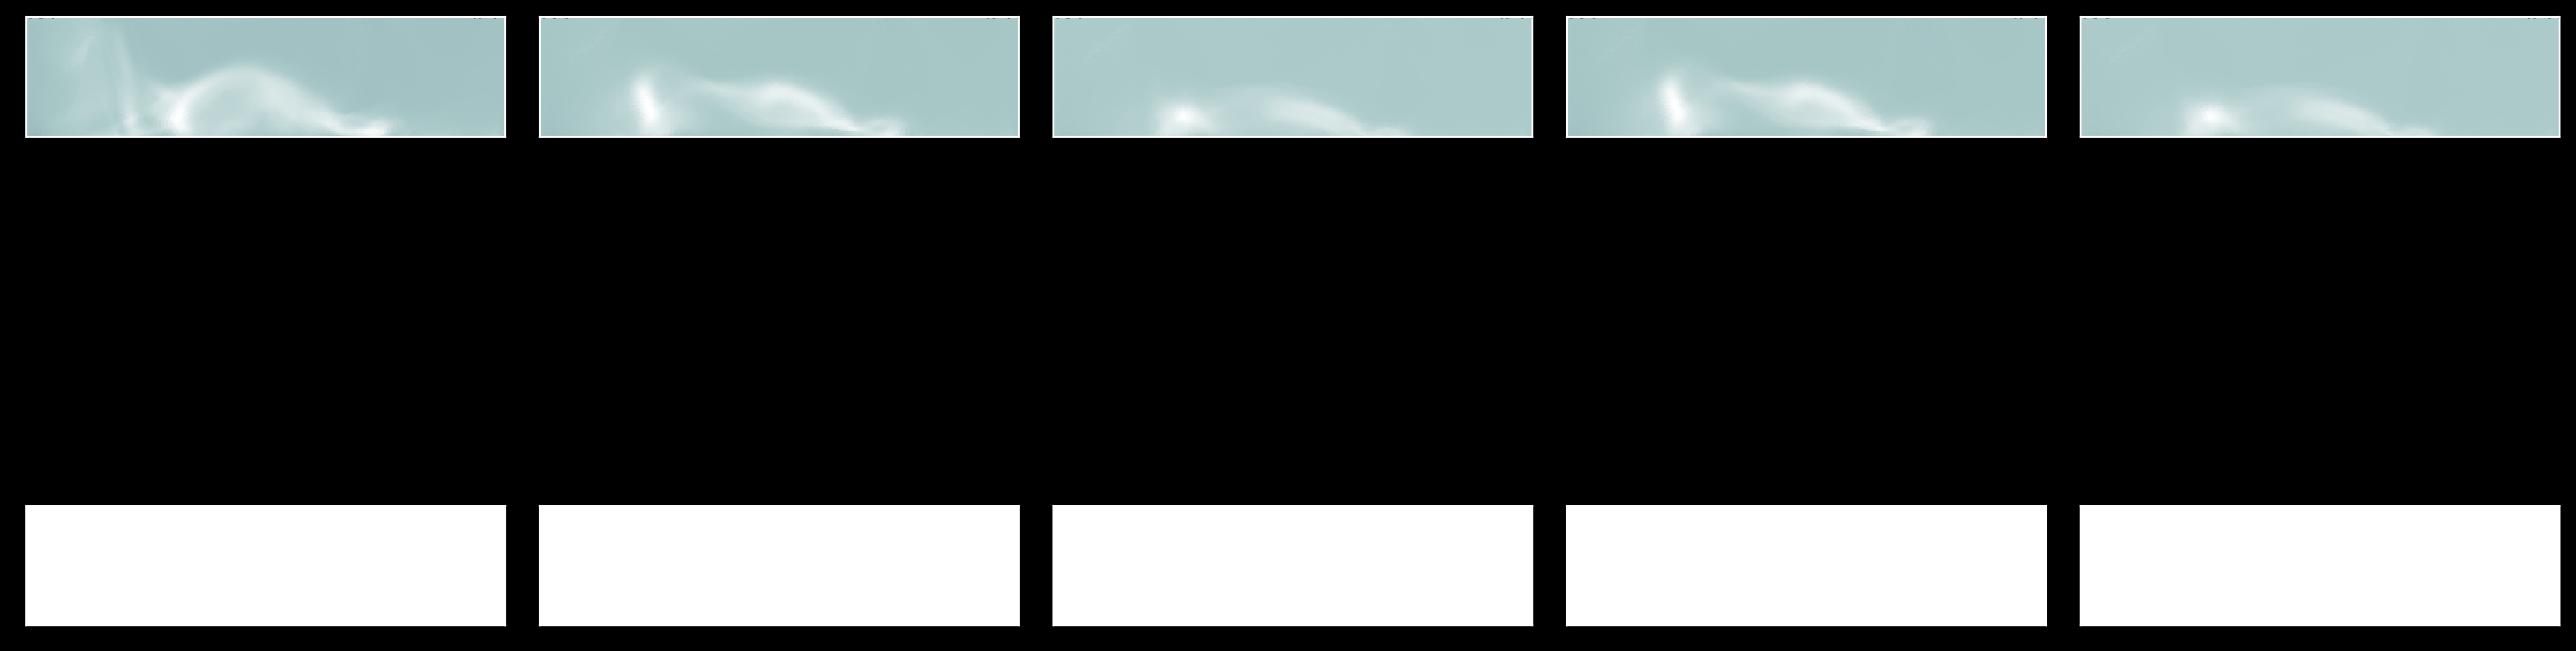

In [90]:
f, axs = plt.subplots(2,5, figsize=(15, 8))
for i, ind in enumerate(np.random.randint(0,9,5)):
    axs[0,i].imshow(original_images[2][ind, 0, :, :], 
                    origin="lower",
                    cmap=lc3_reg)
    axs[0,i].axes.xaxis.set_visible(False)
    axs[0,i].axes.yaxis.set_visible(False)
    axs[1,i].imshow(reconstructed_images[2][ind, 0, :, :],
                   origin="lower",
                   cmap=lc3_reg)
    axs[1,i].axes.xaxis.set_visible(False)
    axs[1,i].axes.yaxis.set_visible(False)
    
f.tight_layout()

In [ ]:
# # plot and check?
# dl_1 = trainloader.__iter__().__next__()

# dl_1.shape
# plt.imshow(dl_1[8][0].cpu(),
#             origin="lower",
#             cmap=lc3_reg)
# plt.title("Sample Plot")
# plt.colorbar(fraction=0.046 * 1/3, pad=0.04)

In [ ]:
# z, mu, logvar, out = model(dl_1.to(device))

In [ ]:
# out.shape

In [ ]:
# bce_loss = mae_loss(out, dl_1.to(device))
# bce_loss

In [ ]:
# KLD = torch.mean(-0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp(), dim = 1), dim = 0)
# KLD

In [ ]:
# EVERYTHING IS NAN. NEED TO REWRITE IN SIMPLER UPDATE STEPS!!!!!!

In [ ]:
# epochs = 20

# train_loss = []
# valid_loss = []
# for epoch in range(epochs):
#     print(f"Epoch {epoch+1} of {epochs}")
#     # beta annealing
#     if epoch<30:
#         beta=0
#     else:
#         beta=1e-4

#     ztrain, train_epoch_loss = train(trainloader, x_all_ics_train, beta, mae_loss)
#     zval, valid_epoch_loss = validate(valloader, x_all_ics_validation, beta, mae_loss)
#     train_loss.append(train_epoch_loss)
#     valid_loss.append(valid_epoch_loss)

#     print(train_loss, valid_loss)
#     # print(f"Train Loss: {train_epoch_loss:.4f}")
#     # print(f"Val Loss: {valid_epoch_loss:.4f}")

Consistently producing `nan` losses! Need to rethink.

Simpler update loop without complicated train-validation routines.